We will now use the TGNN architecture employed in other files as a basis to build a model that is able to perform Emotional Recognition Classification. This task involves classifying the emotional state of speaker utterances in multi-party conversation. 

Lets first read in all the generated graphs. These encompass the training, testing and validation set. 

In [1]:
import pickle 

with open('../graphs/data/ERC/val_dialogue_graphs.pkl', 'rb') as f:
    val_dialogue_graphs = pickle.load(f)

with open('../graphs/data/ERC/test_dialogue_graphs.pkl', 'rb') as f:
    test_dialogue_graphs = pickle.load(f)

with open('../graphs/data/ERC/train_dialogue_graphs.pkl', 'rb') as f:
    train_dialogue_graphs = pickle.load(f)


Lets first define the pytorch geomrtic dataset. 

The dataset object taked in a list of graphs where each graph, 'G', is composed of a sub-graphs 'G_i' where each subgraph represents an utterance.  

Each subggraph G_i has an entry for Structure, 'X', and one for its emotion label, 'Y'. 

X contains node entries where each node has a corresponding embedding and list of edges. 

Consider entry 'X' in graph 'G_0':

A dictionary entry for a speaker node will have a full feature embedding and edges pointing to all other nodes in the time stamp as well as an edge pointing to its future state. 
- Ex. 'D_0': {'embedding': [-0.46728479862213135, -0.20498991012573242, -0.43848446011543274, ....] ,'edges': ['A_0', 'B_0', 'C_0']}

A dictionary entry for a silent node will have a null feature embedding and one edge pointing to its future state. 
- Ex. 'A_0': {'embedding': [NULL] ,'edges': []}


The dataset generates a graph of subgraphs for each conversation. 

In [2]:
import torch
from torch_geometric.data import Data, Dataset
import torch.nn.functional as F

class ERC_Dataset(Dataset):
    def __init__(self, graph_list):
        """
        Initialize the ERC_Dataset object.

        :param graph_list: List of graphs where each graph contains a list of subgraphs.
        """
        super(ERC_Dataset, self).__init__()
        self.graph_list = graph_list
        self.processed_data = self._process_graphs(graph_list)

    def _process_graphs(self, graph_list):
        """
        Process the input list of graphs and combine all subgraphs in each graph into a single PyTorch Geometric Data object.

        :param graph_list: List of graphs where each graph contains a list of subgraphs.
        :return: A list of combined subgraphs represented as a single PyTorch Geometric Data object.
        """
        processed_graphs = []

        for graph in graph_list:
            node_embeddings = []
            edge_list = []
            y_labels = []
    


            # Process each subgraph
            for subgraph in graph:  # Each subgraph contains 'X' and 'Y'
                node_to_idx = {}
                start_idx = len(node_embeddings)
                
                # Process nodes
                for node_name, node_data in subgraph['X'].items():
                    node_idx = len(node_to_idx)
                    node_to_idx[node_name] = start_idx + node_idx
                    node_embeddings.append(node_data['embedding'])

                # Process edges
                for node_name, node_data in subgraph['X'].items():
                    node_idx = node_to_idx[node_name]
                    for edge in node_data['edges']:
                        if edge in node_to_idx:
                            edge_list.append((node_idx, node_to_idx[edge]))

                # Process labels
                emotion_mapping = {'anger': 0, 'disgust': 1, 'sadness': 2, 'joy': 3, 'neutral': 4, 'surprise': 5, 'fear': 6}
                emotion_index = emotion_mapping[subgraph['Y']]
                y_labels.append(emotion_index)

            # Convert embeddings and edges to tensors
            x = torch.tensor(node_embeddings, dtype=torch.float)
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous() if edge_list else torch.empty((2, 0), dtype=torch.long)
            y = torch.tensor(y_labels, dtype=torch.long)
            turns_list = [i for i in range(len(graph))]
            turns = torch.tensor(turns_list, dtype=torch.long)

            # Create a PyTorch Geometric Data object for the big graph
            graph_data = Data(x=x, edge_index=edge_index, y=y, turns=turns)
            processed_graphs.append(graph_data)

        return processed_graphs

    def len(self):
        """
        Return the number of graphs in the dataset.
        """
        return len(self.processed_data)

    def __getitem__(self, idx):
        """
        Get a specific graph by index.

        :param idx: Index of the graph to retrieve.
        :return: A PyTorch Geometric Data object representing the combined graph of subgraphs.
        """
        return self.processed_data[idx]


In [3]:
import torch
from torch_geometric.data import Data, Dataset
import torch.nn.functional as F

class ERC_Dataset_fullyConnected(Dataset):
    def __init__(self, graph_list):
        """
        Initialize the ERC_Dataset object.

        :param graph_list: List of graphs where each graph contains a list of subgraphs.
        """
        super(ERC_Dataset_fullyConnected, self).__init__()
        self.graph_list = graph_list
        self.processed_data = self._process_graphs(graph_list)

    def _process_graphs(self, graph_list):
        """
        Process the input list of graphs and combine all subgraphs in each graph into a single PyTorch Geometric Data object.

        :param graph_list: List of graphs where each graph contains a list of subgraphs.
        :return: A list of combined subgraphs represented as a single PyTorch Geometric Data object.
        """
        processed_graphs = []

        for graph in graph_list:
            node_embeddings = []
            edge_list = []
            y_labels = []
            node_to_idx = {}  # To map node names to their indices across subgraphs

            # Process each subgraph
            for subgraph_idx, subgraph in enumerate(graph):  # Each subgraph contains 'X' and 'Y'
                current_node_to_idx = {}  # Map for nodes in this subgraph
                start_idx = len(node_embeddings)
                
                # Process nodes
                for node_name, node_data in subgraph['X'].items():
                    node_idx = len(current_node_to_idx)
                    current_node_to_idx[node_name] = start_idx + node_idx
                    node_embeddings.append(node_data['embedding'])

                    # If this node has past states, connect it to them
                    for past_idx in range(subgraph_idx):
                        past_node_name = f"{node_name.split('_')[0]}_{past_idx}"
                        if past_node_name in node_to_idx:
                            edge_list.append((node_to_idx[past_node_name], start_idx + node_idx))

                # Update the global node-to-idx map for future subgraph connections
                node_to_idx.update(current_node_to_idx)

                # Process edges within the current subgraph
                for node_name, node_data in subgraph['X'].items():
                    node_idx = current_node_to_idx[node_name]
                    for edge in node_data['edges']:
                        if edge in current_node_to_idx:
                            edge_list.append((node_idx, current_node_to_idx[edge]))

                # Process labels
                emotion_mapping = {'anger': 0, 'disgust': 1, 'sadness': 2, 'joy': 3, 'neutral': 4, 'surprise': 5, 'fear': 6}
                emotion_index = emotion_mapping[subgraph['Y']]
                y_labels.append(emotion_index)

            # Convert embeddings and edges to tensors
            x = torch.tensor(node_embeddings, dtype=torch.float)
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous() if edge_list else torch.empty((2, 0), dtype=torch.long)
            y = torch.tensor(y_labels, dtype=torch.long)
            turns_list = [i for i in range(len(graph))]
            turns = torch.tensor(turns_list, dtype=torch.long)

            # Create a PyTorch Geometric Data object for the big graph
            graph_data = Data(x=x, edge_index=edge_index, y=y, turns=turns)
            processed_graphs.append(graph_data)

        return processed_graphs

    def len(self):
        """
        Return the number of graphs in the dataset.
        """
        return len(self.processed_data)

    def __getitem__(self, idx):
        """
        Get a specific graph by index.

        :param idx: Index of the graph to retrieve.
        :return: A PyTorch Geometric Data object representing the combined graph of subgraphs.
        """
        return self.processed_data[idx]


Below we define the testing, training, and validation sets

In [4]:
training_graphs = ERC_Dataset(train_dialogue_graphs)
validation_graphs = ERC_Dataset(val_dialogue_graphs)
testing_graphs = ERC_Dataset(test_dialogue_graphs)

The function below is used to plot the number fo utterances vs number of participants for each conversation. It is used to gauge the varaibility in the data and compare it to the initial graphs to make sure that the dataset preserves the structure. 

In [5]:
import matplotlib.pyplot as plt

def plot_speakers_vs_utterances(dataset, title):

    num_speakers = []
    num_utterances = []

    # To iterate over each group
    for graph in dataset:
        num_nodes = graph.x.shape[0]
        num_edges = graph.edge_index.shape[1]
        num_turns = num_nodes - num_edges
        num_utterances.append(num_turns)
        num_speakers.append(num_nodes/num_turns)

    
    plt.figure(figsize=(4, 3))
    plt.scatter(num_utterances, num_speakers, color='blue')
    plt.title(f'Number of Speakers vs Number of Utterances ({title})')
    plt.xlabel('Number of Utterances')
    plt.ylabel('Number of Speakers')
    plt.grid(True)
    plt.show()


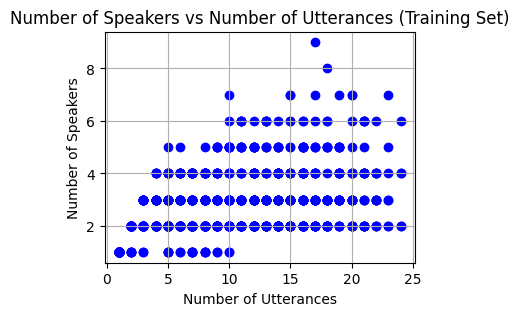

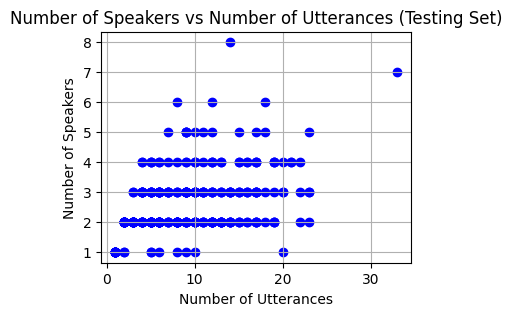

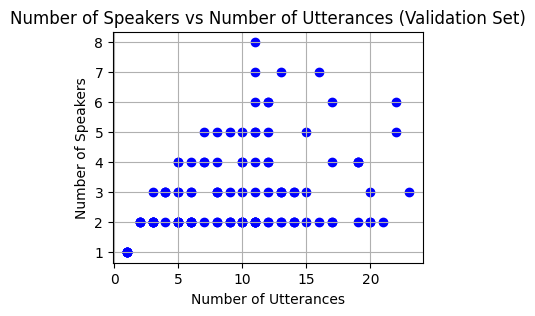

In [6]:
plot_speakers_vs_utterances(training_graphs, 'Training Set')
plot_speakers_vs_utterances(testing_graphs, 'Testing Set')
plot_speakers_vs_utterances(validation_graphs, 'Validation Set')

Below we define the test and train laoder used for model training

In [7]:
from torch_geometric.loader import DataLoader

# Create data loaders as before
train_loader = DataLoader(training_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(testing_graphs, batch_size=32, shuffle=False)

BElow we iterate through a train loader as we will when forward passing. 

In [8]:
for batch_idx, batch in enumerate(train_loader):
    # Use the batch attribute of batches to get number of graphs 
    num_graphs = batch.batch.unique().shape[0]

    current_label_start = 0
    for i in range(num_graphs):

        # Get Nodes
        graph_nodes = (batch.batch == i).nonzero(as_tuple=False).view(-1)  
        x_subgraph = batch.x[graph_nodes]

        # Get Edges
        edge_mask = (batch.edge_index[0].unsqueeze(1) == graph_nodes).any(1) & \
                    (batch.edge_index[1].unsqueeze(1) == graph_nodes).any(1)
        edge_index_subgraph = batch.edge_index[:, edge_mask] - graph_nodes.min()  # Reindex edges to the subgraph node indices

        # Extract labels: subgraphs always equal num nodes - num edges given structure 
        num_subgraphs = x_subgraph.shape[0] -  edge_index_subgraph.shape[1] 
        y_subgraph = batch.y[current_label_start:current_label_start + num_subgraphs] 

        # extract turns
        turns = batch.turns  

        print(f"Graph {i + 1}:")
        print(f"  Subgraph node features shape: {x_subgraph.shape}")
        print(f"  Subgraph edge index shape: {edge_index_subgraph.shape}")
        print(f"  Subgraph labels: {y_subgraph}")

        current_label_start += num_subgraphs
        break
    
    break  


Graph 1:
  Subgraph node features shape: torch.Size([36, 768])
  Subgraph edge index shape: torch.Size([2, 24])
  Subgraph labels: tensor([3, 3, 3, 4, 3, 3, 3, 1, 4, 4, 0, 3])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GlobalAttention
from torch_geometric.data import Data


class FullyConnectedTGNN(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768, output_dim=256, num_heads=4):
        super(FullyConnectedTGNN, self).__init__()
        
        # GATConv for message passing
        self.gat_conv = GATConv(input_dim, hidden_dim, heads=num_heads, concat=False)
        
        # Global attention pooling
        self.attention_layer = nn.Linear(hidden_dim, 1)
        self.global_att_pool = GlobalAttention(self.attention_layer)
        
        # Output layer for classification
        self.classifier = nn.Linear(hidden_dim, output_dim)
    
    def get_subgraph_for_turn(self, graph, turn_idx):
        """
        Generates a subgraph that includes all turns up to the current turn, 
        but only edges pointing to nodes in the current turn.
        
        :param graph: PyTorch Geometric Data object (entire graph)
        :param turn_idx: The current turn index to generate the subgraph for.
        :return: Subgraph of the current turn.
        """
        # Get the node indices for the current and previous turns
        subgraph_nodes = [i for i in range(graph.turns.size(0)) if graph.turns[i] <= turn_idx]
        
        # Get edges where the target node is in the current turn
        subgraph_edges = graph.edge_index[:, (graph.turns[graph.edge_index[1]] == turn_idx)]
        
        # Get the corresponding embeddings for the nodes in the subgraph
        subgraph_x = graph.x[subgraph_nodes]
        
        # Create a new PyTorch Geometric Data object for the subgraph
        subgraph = Data(x=subgraph_x, edge_index=subgraph_edges)
        
        return subgraph, subgraph_nodes  # Return the subgraph and the corresponding node indices in the original graph
    
    def forward(self, batch):
        """
        Forward pass for a batch of graphs.
        :param batch: A batch of graphs.
        """
        # Initialize to store all outputs
        batch_outputs = []
        
        # Get number of graphs in batch
        num_graphs = batch.batch.unique().shape[0]
        
        # Iterate through each graph in the batch
        for i in range(num_graphs):
            # Get the current graph from the batch
            graph_nodes = (batch.batch == i).nonzero(as_tuple=False).view(-1)
            valid_edges_mask = torch.isin(batch.edge_index[0], graph_nodes)
            edge_index_graph = batch.edge_index[:, valid_edges_mask]
            
            graph = Data(
                x=batch.x[graph_nodes], 
                edge_index=edge_index_graph,
                y=batch.y[graph_nodes],
                turns=batch.turns[graph_nodes]
            )
            
            
            # Iterate through the turns in the graph
            graph_outputs = []
            for turn_idx in range(graph.turns.max().item() + 1):
                # Generate subgraph for the current turn
                subgraph, subgraph_nodes = self.get_subgraph_for_turn(graph, turn_idx)
                
                # Apply message passing using GATConv
                subgraph.x = self.gat_conv(subgraph.x, subgraph.edge_index)
                
                # Update the embeddings of the original graph with the updated embeddings from the subgraph
                graph.x[subgraph_nodes] = subgraph.x
                
                # Apply global attention pooling
                pooled_output = self.global_att_pool(subgraph.x)
                
                # Classify using the output from the attention pooling
                output = self.classifier(pooled_output)
                
                # Store the output for the current subgraph (turn)
                graph_outputs.append(output)
            
            # Stack the outputs for all turns in the current graph
            graph_outputs = torch.stack(graph_outputs, dim=0)  # (num_turns, output_dim)
            batch_outputs.append(graph_outputs)
        
        # Stack all graph outputs
        return torch.stack(batch_outputs, dim=0)  # (num_graphs, num_turns, output_dim)


In [10]:
hyperparameters = {
    'num_epochs': 50,  
    'learning_rate': 0.0005,  
    'patience': 5, 
    'print_every': 1  
}

In [11]:
import torch
import torch.optim as optim
import numpy as np

# Define loss function (CrossEntropyLoss for multi-class classification)
loss_fn = torch.nn.CrossEntropyLoss()

# Function for training the model
def train_model(model, train_loader, val_loader, hyperparameters, model_name="best_model.pth"):
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])
    num_epochs = hyperparameters['num_epochs']
    patience = hyperparameters['patience']
    print_every = hyperparameters['print_every']

    best_val_loss = np.inf
    patience_counter = 0

    print("============================= STARTING TRAINING ==================================")

    for epoch in range(num_epochs):
        model.train()  
        train_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            # get predictions and output
            output = model(batch) 
            output = output.squeeze(1)
            labels = batch.y

            # Compute loss for batch
            batch_loss = loss_fn(output, labels)

            # Backward pass and optimization
            batch_loss.backward()
            optimizer.step()
            
            train_loss += batch_loss.item()



        # Evaluate on validation set
        val_loss = evaluate_model(model, val_loader)

        # Print updates every n epochs
        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save model if it improves
            torch.save(model.state_dict(), f'ERC_Models/{model_name}.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

# Function for evaluating the model on validation/test sets
def evaluate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            output = model(batch)
            output = output.squeeze(1)
            labels = batch.y  # Assuming batch contains ground truth labels for subgraphs
            
            # Compute validation loss
            loss = loss_fn(output, labels)
            val_loss += loss.item()

    return val_loss / len(val_loader)


In [12]:
from ERC_working_models import ITERMEM, SIMPT

In [13]:
model = SIMPT()

train_model(model, train_loader, val_loader, hyperparameters, model_name="ITERMEM_Tweaked")

/Users/manuelnunezmartinez/Documents/UF/Research/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


============================= STARTING TRAINING ==================================
Epoch [1/50], Train Loss: 52.8255, Val Loss: 1.6200
Epoch [2/50], Train Loss: 49.9569, Val Loss: 1.6050
Epoch [3/50], Train Loss: 49.5731, Val Loss: 1.6103
Epoch [4/50], Train Loss: 49.2957, Val Loss: 1.6218
Epoch [5/50], Train Loss: 49.3137, Val Loss: 1.5911
Epoch [6/50], Train Loss: 48.9615, Val Loss: 1.5828
Epoch [7/50], Train Loss: 48.6362, Val Loss: 1.5822
Epoch [8/50], Train Loss: 48.6445, Val Loss: 1.5927


KeyboardInterrupt: 

The function below evaluates a model, plots a confusion matrix, and print the weighted F1 score 

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def evaluate_and_confusion_matrix(model, classes):
    """
    Evaluates the model on the test set and returns a confusion matrix along with the weighted F1 score.

    :param model: Trained model
    :param test_loader: DataLoader for the test set
    :param classes: List of class names corresponding to labels
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            output = model(batch)  # Forward pass
            
            # Get predicted classes (apply softmax, argmax for classification)
            predicted_classes = torch.argmax(output, dim=2).squeeze(1)  

            # Store predictions and true labels
            all_preds.append(predicted_classes.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())
    
    # Flatten the lists to a single array
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Display confusion matrix using matplotlib
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Compute the weighted F1 score across all classes
    weighted_f1_score = f1_score(all_labels, all_preds, average='weighted')  # 'weighted' accounts for class imbalance
    print(f"Weighted F1 Score: {weighted_f1_score:.4f}")

    return cm, weighted_f1_score


/Users/manuelnunezmartinez/Documents/UF/Research/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


The functions below are helper functions for th heatmap function. 

In [16]:
def split_conversations(preds, labels, turns):
        conversations_preds = []
        conversations_labels = []
        conversations_turns = []
        
        current_preds = []
        current_labels = []
        current_turns = []

        for i in range(len(turns)):
            if turns[i] == 0 and i != 0:  # New conversation starts when turns[i] == 0
                conversations_preds.append(current_preds)
                conversations_labels.append(current_labels)
                conversations_turns.append(current_turns)
                
                current_preds = []
                current_labels = []
                current_turns = []
            
            current_preds.append(preds[i])
            current_labels.append(labels[i])
            current_turns.append(turns[i])

        # Append the last conversation
        if current_preds:
            conversations_preds.append(current_preds)
            conversations_labels.append(current_labels)
            conversations_turns.append(current_turns)
        
        return conversations_preds, conversations_labels, conversations_turns

def get_turn_category(num_turns, bins):
    """Determine which category a conversation's number of turns belongs to."""
    if num_turns == bins['single']:
        return 'single'
    elif num_turns == bins['double']:
        return 'double'
    elif bins['short'][0] <= num_turns <= bins['short'][1]:
        return 'short'
    elif bins['mid'][0] <= num_turns <= bins['mid'][1]:
        return 'mid'
    elif num_turns >= bins['long']:
        return 'long'
    return None

Th heatmap function below generate an accuracy heatmap for turn percentiles based on meetinng length. 

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_by_exchange_length(model, classes, bins={"single": 1, "double": 2, "short": (3, 10), "mid": (10, 20), "long": 20}):

    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    all_turns = []
    
    with torch.no_grad():
        for batch in test_loader:
            output = model(batch)  # Forward pass
            predicted_classes = torch.argmax(output, dim=2).squeeze(1)  # Shape: (batch_size,)
            all_preds.append(predicted_classes.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())
            all_turns.append(batch.turns.cpu().numpy())

    # Flatten the lists to single arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_turns = np.concatenate(all_turns)
    
    # Step 1: Split by conversations 
    conversations_preds, conversations_labels, conversations_turns = split_conversations(all_preds, all_labels, all_turns)

    # Dictionary to hold correct and total predictions for each category and percentile
    categories = ['single', 'double', 'short', 'mid', 'long']
    correct_by_cat_emotion = {cat: {p: {c: 0 for c in range(len(classes))} for p in range(3)} for cat in categories}
    total_by_cat_emotion = {cat: {p: {c: 0 for c in range(len(classes))} for p in range(3)} for cat in categories}

    #Process conversations and fill the dictionaries
    for preds, labels, turns in zip(conversations_preds, conversations_labels, conversations_turns):
        num_turns = len(turns)
        category = get_turn_category(num_turns, bins)

        if category:
            for i in range(num_turns):
                true_emotion = labels[i]
                predicted_emotion = preds[i]
                # Assign percentile 
                turn_percentile = min(2, i // (num_turns // 3) if num_turns > 2 else i)
                # Update total occurrences for the true emotion at this turn
                total_by_cat_emotion[category][turn_percentile][true_emotion] += 1
                # Update correct predictions if the prediction is correct
                if predicted_emotion == true_emotion:
                    correct_by_cat_emotion[category][turn_percentile][true_emotion] += 1

    
    # Generate heatmaps for each conversation category
    for category in categories:
        # Prepare the numeric accuracy matrix 
        accuracy_matrix = np.zeros((len(classes), 3)) 
        fraction_matrix = np.full((len(classes), 3), '', dtype=object)  # Placeholder for fractions

        for p in range(3):
            for emotion in range(len(classes)):
                if total_by_cat_emotion[category][p][emotion] > 0:
                    accuracy_matrix[emotion][p] = correct_by_cat_emotion[category][p][emotion] / total_by_cat_emotion[category][p][emotion]
                    fraction_matrix[emotion][p] = f'{correct_by_cat_emotion[category][p][emotion]} / {total_by_cat_emotion[category][p][emotion]}'
                else:
                    fraction_matrix[emotion][p] = '0 / 0'

        # Generate the heatmap for shading
        plt.figure(figsize=(8, 6))
        ax = sns.heatmap(accuracy_matrix, annot=False, cmap='Blues', xticklabels=['1st Third', '2nd Third', 'Last Third'], yticklabels=classes)

        # Overlay text (fractions) on top of the heatmap
        for i in range(len(classes)):
            for j in range(3):
                ax.text(j + 0.5, i + 0.5, fraction_matrix[i][j], color='black', ha='center', va='center', fontsize=12)

        plt.title(f"Emotion Prediction Accuracy by Percentile - {category.capitalize()} Exchanges")
        plt.xlabel("Conversation Stage")
        plt.ylabel("Emotions")
        plt.show()



Below we evaluate the model using both evaluation functions. 

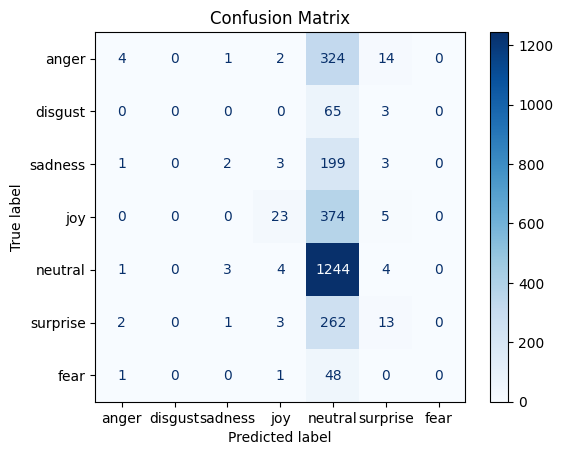

Weighted F1 Score: 0.3467


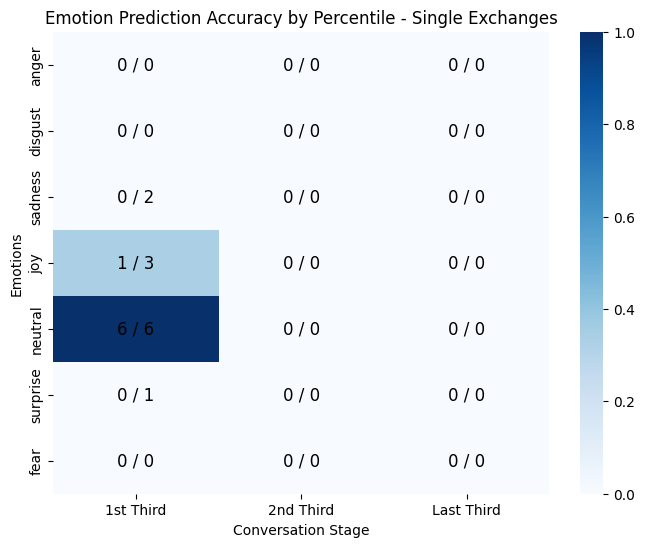

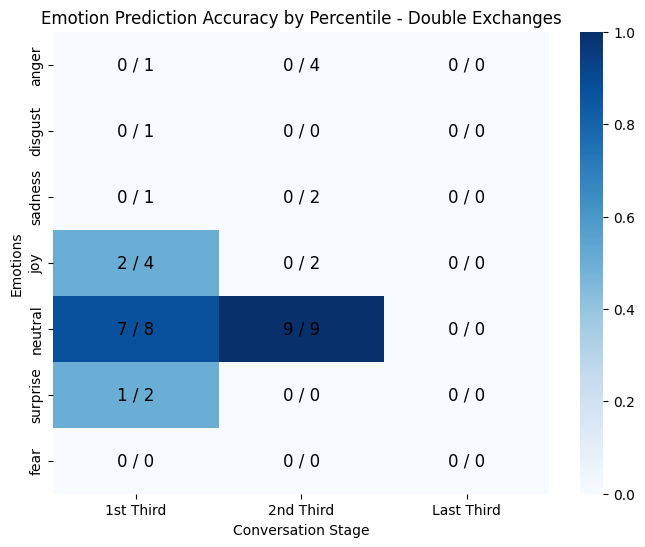

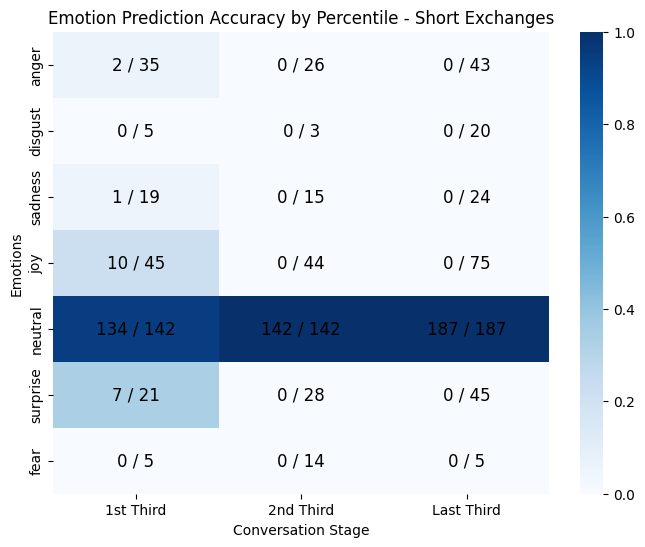

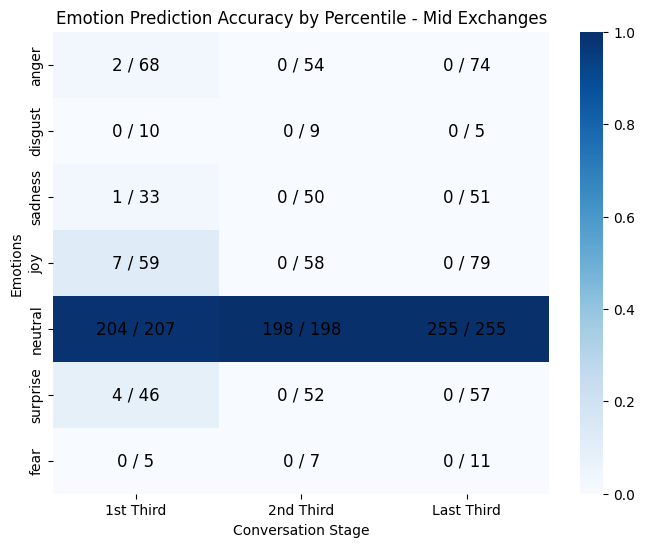

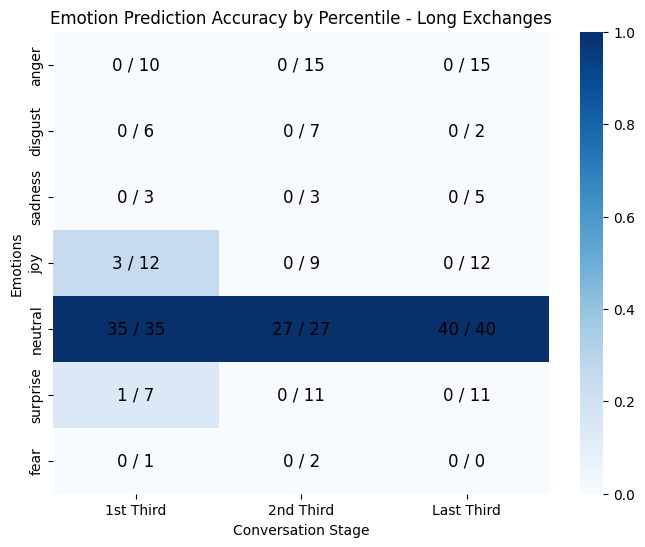

In [18]:
# Load the saved model's state dictionary
model.load_state_dict(torch.load('ITERMEM_Tweaked.pth'))

class_names = ['anger', 'disgust', 'sadness', 'joy', 'neutral', 'surprise', 'fear']

evaluate_and_confusion_matrix(model, class_names)
evaluate_model_by_exchange_length(model, class_names)